# Evaluating Tackle Difficulty with NFL Tracking Data

I never actually played football, but I did play rugby for a long time. Doing so gave me a distinct appreciation for the difference between the bread-and-butter tackles and the ones that really made you think "wow, that guy can _tackle_." Said another way, not all taclkes are created equal; a range of contextual factors determine how impressive or impactful a particular tackle is. Did Rudy just tackle some guy twice his size? Were there four defenders nearby and someone was going to make a tackle? Did the tackler drag the ball carrier down slowly while he trundled for an extra 5 yards, or decisively sit him back down?

My goal here is to leverage the NFL tracking data to develop new metrics for measuring tackling that account for these contextual factors. Specifically, I want to develop two different types of metrics that measure a player's or team's ability to

1. make difficult tackles, and
2. prevent ball carriers from acquiring additional yardage during the tackle.

In each case we want to be able to compare the difficulty of the tackle to how the tackler actually did.  To do so, I will take the following approach

* derive a collection of _features_ that represent the _context_ of the tackle event (e.g., how fast were the players moving relative to one another)
* fit a simple model to predict the _outcome_ of the event given said context (e.g., making that tackle was a miracle)
* compute metrics based on the difference between the _predicted outcome_ and the _true outcome_ (e.g., this guy makes a lot of miraculous tackles).

To avoid letting great be the enemy of good, I'm going to make some approximations at various stages to simplify some of the work and make the whole thing more readable. After all, right now we are designing new metrics, not tweaking them! But, I'll try to denote such things as an "Area For Improvement" (AFI) when they show up.

## Data Processing

The backbone of our analysis will be a dataframe similar to the tracking data, but where each row reflects _two_ players

1. the ball carrier, as identified by the `plays.csv`
2. each defender (i.e., potential tackler)

In addition to the provided tracking data (e.g., position, speed, acceleration), we enrich the dataframe with the physical attributes of the carrier and defender (from `players.csv`), and indicators regarding whether the defender recorded a tackle, assist or missed tackle on the play (from `tackles.csv`). We also only include frames between an event that could have transferred the ball to the carrier (see `DataProcessor.CARRY_START_EVENTS`) to the last non-null (play-ending) event recorded.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from os import getenv
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

pd.set_option("display.max_columns", None)

In [2]:
# Pesky `is_sparse` warnings...
import warnings
warnings.filterwarnings('ignore')

In [3]:
class DataProcessor:
    PLAYIDS = ["gameId", "playId"]
    CARRY_START_EVENTS = {
        "run",
        "handoff",
        "pass_outcome_caught",
        "snap_direct"
    }
    
    @classmethod
    def construct_ball_carrier_view(cls, plays, tracking):
        """
        Construct a view of tracking data focused on ball carriers,
        subset to the frames where they have the ball
        """
        ball_carriers = tracking.merge(
            play_df[cls.PLAYIDS + ["ballCarrierId"]],
            left_on=cls.PLAYIDS + ["nflId"],
            right_on=cls.PLAYIDS + ["ballCarrierId"]
        )
        # take last non-NA event as end of play
        play_end = ball_carriers.dropna(subset="event").drop_duplicates(
            subset=cls.PLAYIDS, keep="last"
        )[cls.PLAYIDS + ["frameId", "event", "x"]].rename(
            columns=dict(frameId="endFrameId", event="endEvent", x="x_final")
        )
        # consider class of events that are valid for ball carrier to have received the ball
        carry_start = ball_carriers[
            ball_carriers.event.isin({"run", "handoff", "pass_outcome_caught", "snap_direct"})
        ].drop_duplicates(
            subset=cls.PLAYIDS, keep="last"
        )[cls.PLAYIDS + ["frameId", "event"]].rename(
            columns=dict(frameId="startFrameId", event="receiptEvent")
        )
        carry_window = carry_start.merge(play_end, on=cls.PLAYIDS)

        # extract only those frames between ball receipt and end of play
        ball_carriers = ball_carriers.merge(
            carry_window,
            on=cls.PLAYIDS
        )

        angle_to_downfield = np.pi * np.where(
            ball_carriers.playDirection == "right",
            ball_carriers.dir - 90,
            ball_carriers.dir - 270
        ) / 180
        ball_carriers["s_downfield"] = ball_carriers.s * np.cos(angle_to_downfield)
        
        return ball_carriers[
            ball_carriers.frameId.between(ball_carriers.startFrameId, ball_carriers.endFrameId)
        ].reset_index(drop=True).astype({"nflId": "int", "jerseyNumber": "int"})
        
    @classmethod
    def construct_defender_view(cls, carriers, tracking, nearby_radius=5):
        """
        Given a carrier view, determine where the defenders are relative to the carrier
        """
        mergeby = cls.PLAYIDS + ["frameId"]

        # Right now really "all others" instead of defenders, but we're going to drop
        # the same-team players shortly, so just use _defenders as a suffix for now
        others = carriers.merge(
            tracking.drop(columns=["playDirection", "time", "event"]),
            on=mergeby, suffixes=("_carrier", "_defender")
        )
        others.nflId_defender = others.nflId_defender.fillna(0).astype("int")
        others["dist_to_carrier"] = np.sqrt(
            np.power(others.x_carrier - others.x_defender, 2) + np.power(others.y_carrier - others.y_defender, 2)
        )

        # Compute how many same team players are nearby
        support = others[
            (others.club_defender == others.club_carrier) & (others.nflId_defender != others.nflId_carrier)
        ]
        support_nearby = support[
            support.dist_to_carrier < nearby_radius
        ].groupby(mergeby).nflId_defender.nunique().rename("blockers_nearby")
        n_pre_merge = len(others)
        others = others.merge(
            support_nearby,
            left_on=mergeby,
            right_index=True,
            how="left"
        )
        others.blockers_nearby = others.blockers_nearby.fillna(0).astype("int")
        assert len(others) == n_pre_merge, f"lost rows in carrier support merge: {len(others)} vs {n_pre_merge}"
        
        defenders = others[
            (others.club_defender != others.club_carrier) & (others.club_defender != "football")
        ].reset_index(drop=True).astype({"jerseyNumber_defender": "int"})
        defenders_nearby = defenders[
            defenders.dist_to_carrier < nearby_radius
        ].groupby(mergeby).nflId_defender.nunique().rename("defenders_nearby")
        n_pre_merge = len(defenders)
        defenders = defenders.merge(
            defenders_nearby,
            left_on=mergeby,
            right_index=True,
            how="left"
        )
        defenders.defenders_nearby = defenders.defenders_nearby.fillna(0).astype("int")
        assert len(defenders) == n_pre_merge, f"lost rows in defender support merge: {len(defenders)} vs {n_pre_merge}"
        
        return defenders

    @classmethod
    def add_physical_characteristics(cls, defenders, players):
        """
        Add some data about the defender and carrier involved
        """
        height = players.height.str.split("-")
        players["height_m"] = (
            height.str[0].astype("int") + height.str[1].astype("int") / 12
        ) * 0.3048
        players = players.set_index("nflId")[["weight", "position", "height_m"]]
        defenders = defenders.merge(
            players,
            left_on="nflId_carrier",
            right_index=True
        )
        defenders = defenders.merge(
            players,
            left_on="nflId_defender",
            right_index=True,
            suffixes=("_carrier", "_defender")
        )
        
        return defenders

    @classmethod
    def add_labels(cls, defenders, tackles):
        defenders = defenders.merge(
            tackles,
            left_on=DataProcessor.PLAYIDS + ["nflId_defender"],
            right_on=DataProcessor.PLAYIDS + ["nflId"],
            how="left"
        ).drop(columns="nflId")
        map_cols = [c for c in tackles if c != "nflId"]
        defenders[map_cols] = defenders[map_cols].fillna(0).astype("int")
        return defenders

    @classmethod
    def pipeline(cls, plays, players, tackles, tracking_dfs):
        defenders = []
        for _df in tqdm(tracking_dfs):
            if isinstance(_df, Path):
                _df = pd.read_csv(_df)
            carriers = DataProcessor.construct_ball_carrier_view(plays, _df)
            _defenders = DataProcessor.construct_defender_view(carriers, _df)
            _defenders = DataProcessor.add_physical_characteristics(_defenders, players)
            _defenders = DataProcessor.add_labels(_defenders, tackles)
            defenders.append(_defenders)
        defenders = pd.concat(defenders).reset_index(drop=True)
        return defenders.sort_values(cls.PLAYIDS + ["frameId", "nflId_defender"]).reset_index(drop=True)

In [4]:
data_dir = Path(getenv("HOME"), "data/nfl-big-data")
assert data_dir.exists()

In [5]:
sorted(data_dir.glob("*.csv"))

[PosixPath('/Users/jkearney/data/nfl-big-data/games.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/players.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/plays.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tackles.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_1.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_2.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_3.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_4.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_5.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_6.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_7.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_8.csv'),
 PosixPath('/Users/jkearney/data/nfl-big-data/tracking_week_9.csv')]

In [6]:
tracking_dfs = sorted(data_dir.glob("tracking_week_*.csv"))
assert len(tracking_dfs), "no tracking dfs"
play_df = pd.read_csv(Path(data_dir, "plays.csv"))
tackle_df = pd.read_csv(Path(data_dir, "tackles.csv"))
players_df = pd.read_csv(Path(data_dir, "players.csv"))

In [7]:
defenders = DataProcessor.pipeline(play_df, players_df, tackle_df, tracking_dfs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:04<00:00,  7.19s/it]


In [8]:
# Note we've dropped a very small number of more complex plays/outcomes that had tackles,
# e.g., including laterals and fumble recoveries. As this is a small proportion, we ignore it for now (AFI)
len(
    set([tuple(x) for x in tackle_df[["gameId", "playId"]].values]) -
    set([tuple(x) for x in defenders[["gameId", "playId"]].values])
)

18

For instance, here's the 11 lines (= 11 defenders) corresponding to one particular frame of one particular play in which Stefon Diggs has just been tackled by Jalen Ramsey.

In [9]:
defenders.query(
    "gameId == 2022090800 & playId == 56 & frameId == 18"
)

,gameId,playId,nflId_carrier,displayName_carrier,frameId,time,jerseyNumber_carrier,club_carrier,playDirection,x_carrier,y_carrier,s_carrier,a_carrier,dis_carrier,o_carrier,dir_carrier,event,ballCarrierId,startFrameId,receiptEvent,endFrameId,endEvent,x_final,s_downfield,nflId_defender,displayName_defender,jerseyNumber_defender,club_defender,x_defender,y_defender,s_defender,a_defender,dis_defender,o_defender,dir_defender,dist_to_carrier,blockers_nearby,defenders_nearby,weight_carrier,position_carrier,height_m_carrier,weight_defender,position_defender,height_m_defender,tackle,assist,forcedFumble,pff_missedTackle
132,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,38577,Bobby Wagner,45,LA,78.62,32.31,1.76,3.13,0.19,0.84,34.12,1.695789,0,3,191,WR,1.8288,242,ILB,1.8288,0,0,0,0
133,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,41239,Aaron Donald,99,LA,91.04,27.66,2.16,1.98,0.22,273.18,263.65,13.245384,0,3,191,WR,1.8288,280,DT,1.8542,0,0,0,0
134,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,42816,Troy Hill,2,LA,69.38,10.33,2.91,0.59,0.29,2.85,353.42,25.538068,0,3,191,WR,1.8288,184,CB,1.8034,0,0,0,0
135,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,43294,Jalen Ramsey,5,LA,78.66,33.87,1.10,3.17,0.12,116.19,127.74,0.670298,0,3,191,WR,1.8288,208,CB,1.8542,1,0,0,0
136,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,43298,Leonard Floyd,54,LA,90.93,31.87,1.37,0.39,0.14,152.86,230.91,11.767770,0,3,191,WR,1.8288,240,DE,1.9558,0,0,0,0
137,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,43335,A'Shawn Robinson,94,LA,86.57,25.33,1.66,1.10,0.18,306.52,275.15,11.180698,0,3,191,WR,1.8288,330,DT,1.9304,0,0,0,0
138,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,47844,Taylor Rapp,24,LA,77.86,26.75,2.96,2.20,0.31,324.09,345.27,7.250579,0,3,191,WR,1.8288,208,FS,1.8288,0,0,0,0
139,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,47917,Greg Gaines,91,LA,86.23,31.96,1.29,1.98,0.14,269.07,305.16,7.154167,0,3,191,WR,1.8288,312,NT,1.8542,0,0,0,0
140,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,48026,Nick Scott,33,LA,65.11,23.07,3.12,0.83,0.31,43.81,43.50,17.844237,0,3,191,WR,1.8288,200,SS,1.8034,0,0,0,0
141,2022090800,56,42489,Stefon Diggs,18,2022-09-08 20:24:06.900000,14,BUF,left,79.33,33.85,0.62,1.31,0.06,100.54,78.02,tackle,42489,6,pass_outcome_caught,18,tackle,79.33,-0.606496,52607,Jordan Fuller,4,LA,72.19,33.21,3.50,2.47,0.36,97.98,101.27,7.168626,0,3,191,WR,1.8288,205,SS,1.8796,0,0,0,0


This leaves us with 12,468 plays for which we have this "complete view," of which 12,007 have a tackle, assist or miss.

In [10]:
defender_tackles = defenders.groupby(["gameId", "playId"])[["tackle", "assist", "pff_missedTackle"]].any()
print(
    f"total number of plays = {defender_tackles.shape[0]:,}, "
    f"with tackle or miss = {defender_tackles.any(axis=1).sum():,}")
defender_tackles.sum()

total number of plays = 12,468, with tackle or miss = 12,007


tackle              9905
assist              3484
pff_missedTackle    1774
dtype: int64

## Metric 1: Tackles Above Replacement (TAR)

To quantify "tackle difficulty," we introduce a metric we call (in a nod to baseball sabermetrics) "Tackles Above Replacement" (TAR), defined as
\begin{align}
TAR & = \sum_{tackles} 1 - p_\theta(\text{tackle} | \text{context})
\end{align}
where $p_\theta$ represents our model that tells us "given the context of the tackle (attempt), how likely is it that the defender made the tackle?" I.e., an impossible tackle should have $p_\theta = 0$, such that when a defender makes such a tackle the contribution to TAR is 1. Conversely, a trivial tackle (with $p_\theta = 1$) does not increase TAR at all.

One obvious shortcoming of such a metric, though, is that it doesn't take into account missed tackles. For this, we consider a modification TAR+ defined as
\begin{align}
TAR+ & = \sum_{tackles} (1 - p_\theta) - \sum_{misses} p_\theta
\end{align}
TAR+ penalizes players for missing tackles, again proportional to the difficulty of the tackle; tackles that were easy to make ($p_\theta = 1$) carry large penalties, while tackles that were hard carry negligible penalties. Note that this is still not a perfect metric as players can avoid be penalized at all by, e.g., not attempting tackles. One way to address this would be by defining a metric over all opportunities (AFI).

**How do we compute $p_\theta$?** We will make use of the labeled Pro Football Focus missed tackle data to fit a classification model that predicts, given features/context, the likelihood that the tackle was made.

**What features do we use?** The data are pretty rich, and so there's a whole host of possible features. However to keep things simple and interpretable (and avoid overfitting), we will use the following set motivated by my own personal (and, occasionally, painful) experience:

1. `s_carrier` = the speed of the carrier...guys moving fast are generally harder to tackle
1. `p_carrier` = the momentum of the carrier...more momentum means the tackler needs more force to stop them
1. `p_rel` = the _relative momentum_ between the carrier and defender, i.e., accounting for their directions...this is a measure of how big the potential size of the impact
1. `o_rel` = the _relative orientation_ of the two players, from facing same direction (0) to head on (1)...colliding with a hip vs a chest is very different
1. `rel_height` = height of defender / height of carrier...taller tacklers can wrap up smaller carriers more easily
1. `time_since_receipt` = time since the carrier received the ball...if the carrier is focused on receiving the ball, they are potentially easier to tackle
1. `sideline_dist` = distance to the closest sideline...getting pushed out of bounds counts as a tackle!
1. `is_caught_pass` = 1 if the carrier receive the ball via a pass...catching a pass requires more focus, and permits less ability to be evasive, than receiving a handoff
1. `is_qb` = 1 if the carrier is the quarterback...QBs are generally easier to tackle, especially as they are generally wisely instructed not to let themselves get hit hard
1. `net_defenders_nearby` = # defenders within 5 yards - # potential blockers within 5 yards...if there are 5 defenders nearby the carrier and no blockers, likelihood is that someone is taking the carrier down
1. `congestion` = # defenders within 5 yards + # potential blockers within 5 yards...not a lot of room to run if there's a bunch of people nearby

**When do we compute these features?** It's clear from a bit of time looking at the data that `event == tackle` indicates when the ball carrier is down, meaning their state has already been significant altered by impact with the tackler. I.e., at this point, the tackle has already been determined. One way of seeing this is the plot below, which shows that tacklers and ball carriers are considerably more "spread out" by the time `event == tackle` as compared to when they are at their closest. This is consistent with both being sprawled on the ground.

Instead, what we want is some measure of these features _going into the tackle_. **We will define this beginning of a "tackle opportunity" to be the first point at which the tackler gets to within 1.5 yards of the ball carrier** because

1. as we can see below, most successful tacklers get within that distance (what's going on with those who don't? AFI!)
2. Recent NFL combine reports suggest most players have a wingspan of just over 2 yards, suggesting most are probably not quite in contact with the carrier by this time. However, defenders approaching attackers are typically going around 3 yards per second, suggesting they're only a few hundred milliseconds from making contact.
3. This is just beyond how far away I'd start dropping into a tackle stance when I was playing rugby.

So this suggests 1.5 yards is a pretty good "point of no return." Really something dynamic would be better (i.e., based on the relative velocity between the players). Another AFI!

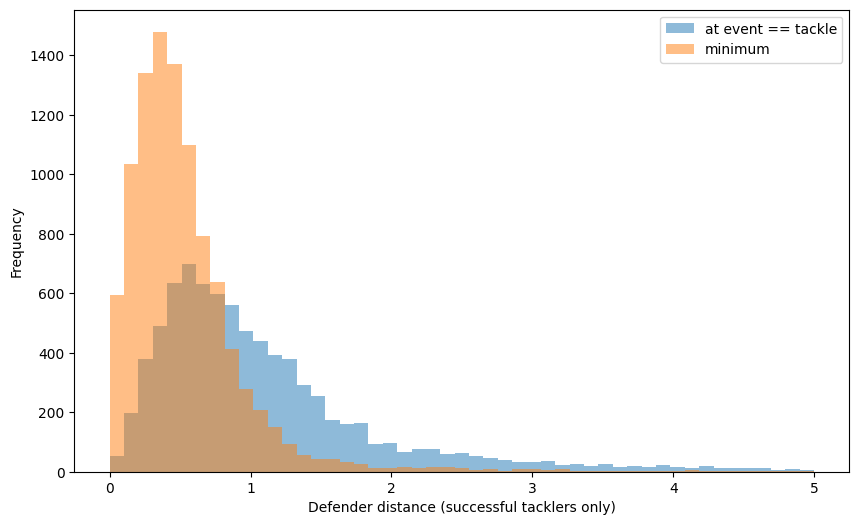

In [11]:
plt.figure(figsize=(10, 6))
hkw = dict(bins=np.linspace(0, 5, 50), alpha=0.5)
defenders.query("tackle == 1 & event == 'tackle'").dist_to_carrier.plot.hist(**hkw, label="at event == tackle")
defenders.query("tackle == 1").groupby(["gameId", "playId"]).dist_to_carrier.min().plot.hist(**hkw, label="minimum")
plt.xlabel("Defender distance (successful tacklers only)")
plt.legend(loc="upper right")
plt.show()

In [12]:
players_df.weight.mean()

245.72430184194891

In [13]:
class TackleFeatures:
    WEIGHT_NORM = 250 # Scale by approximate mean player weight to keep values sensible
    FWIDTH = 53.3
    PLAYDEF = ["gameId", "playId", "nflId_defender"]
    
    @classmethod
    def relative_angle(cls, theta_carrier, theta_defender):
        theta_rel = theta_defender - theta_carrier
        return np.where(
            theta_rel.between(-180, 180),
            np.abs(theta_rel),
            360 - np.abs(theta_rel)
        ) / 180

    @classmethod
    def relative_vector_magnitude(cls, s_carrier, s_defender, theta_rel):
        return np.sqrt(
            np.power(s_carrier, 2) + np.power(s_defender, 2) - 2 * s_carrier * s_defender * np.cos(np.pi * theta_rel)
        )
        
    @classmethod
    def add_tackle_features(cls, defenders):
        existing_features = ["s_carrier"]
        
        defenders["p_carrier"] = defenders.s_carrier * (defenders.weight_carrier / cls.WEIGHT_NORM)
        p_defender = defenders.s_defender * (defenders.weight_defender / cls.WEIGHT_NORM)
        dir_rel = cls.relative_angle(defenders.dir_carrier, defenders.dir_defender)

        defenders["p_rel"] = cls.relative_vector_magnitude(
            defenders.p_carrier, p_defender, dir_rel
        )
        defenders["o_rel"] = cls.relative_angle(defenders.o_carrier, defenders.o_defender)

        defenders["rel_height"] = defenders.height_m_defender / defenders.height_m_carrier

        # Frames appear to be about 1ms apart, so just use that to avoid datetime nonsense
        defenders["time_since_receipt"] = 0.1 * (defenders.frameId - defenders.startFrameId)

        defenders["sideline_dist"] = np.minimum(
            defenders.y_carrier, cls.FWIDTH - defenders.y_carrier
        ) / cls.FWIDTH * 2

        defenders["is_caught_pass"] = (defenders.receiptEvent == "pass_outcome_caught").astype("int")

        defenders["is_qb"] = (defenders.position_carrier == "QB").astype("int")

        defenders["net_defenders_nearby"] = defenders.defenders_nearby - defenders.blockers_nearby
        defenders["congestion"] = defenders.defenders_nearby + defenders.blockers_nearby

        new_f_idx = defenders.columns.get_loc("p_carrier")
        return existing_features + defenders.columns.tolist()[new_f_idx:]

    @classmethod
    def extract_tackle_opps(cls, defenders, tackle_dist=1.5):
        # Extract all defenders get closer enough to the defender to potentially
        # make a tackle
        dsorted = defenders[
            (defenders.dist_to_carrier <= tackle_dist) &
            defenders[["tackle", "assist", "pff_missedTackle"]].any(axis=1)
        ].sort_values(
            cls.PLAYDEF + ["frameId"]
        ).reset_index(drop=True)

        # A bit of trickery to assign a "tackle opportunity index" = tidx to each carrier/defender interaction.
        # Note that, in some cases, there can be multiple such events in the same play if
        # the defender gets father and then closer. We will detect this via
        # "skips" in frames (as we've already focused only on frames where the two are close)
        dsorted["tidx"] = (
            dsorted[cls.PLAYDEF].diff().any(axis=1) |
            (dsorted.frameId.diff() != 1)
        ).cumsum()

        # We only care about the state at the beginning of each opportunity
        dsorted = dsorted.drop_duplicates("tidx", keep="first")

        # Assume tackles & assists only happen on the last opportunity
        final_opp_idx = dsorted.groupby(cls.PLAYDEF).tidx.max().rename("tidx_max")
        dsorted = dsorted.merge(final_opp_idx, left_on=cls.PLAYDEF, right_index=True)
        dsorted[["tackle", "assist"]] = dsorted[["tackle", "assist"]] * (
            dsorted.tidx_max == dsorted.tidx
        ).astype("int").values.reshape((-1, 1))
        # Drop resulting cases where we have an opp without a tackle as it has been reassigned
        dsorted = dsorted[
            dsorted[["tackle", "assist", "pff_missedTackle"]].any(axis=1)
        ].reset_index(drop=True)
        dsorted = dsorted.drop(columns=["tidx_max"])
        # If there's a tackle or assist in the opportunity, we'll say there's not a miss
        dsorted.pff_missedTackle = dsorted.pff_missedTackle * (1 - dsorted[["tackle", "assist"]].sum(axis=1))
        # Note: could also condition missed tackles must come before tackles?

        # Compute weights
        weights = 1 / dsorted.groupby(cls.PLAYDEF).pff_missedTackle.sum().rename("weight")
        weights = weights.fillna(1)
        dsorted = dsorted.merge(
            weights, left_on=cls.PLAYDEF, right_index=True
        )
        dsorted.weight = np.where(
            dsorted.pff_missedTackle == 1,
            dsorted.weight,
            1
        )
        
        tackle_features = cls.add_tackle_features(dsorted)
        return dsorted, tackle_features

One more hopefully not-too-confusing digression regarding approximations, and hopefully explaining `TackleFeatures.extract_tackle_opps` above: in general, while we know from `tackles.csv` whether a player recorded a tackle/assist/miss, we don't have the labels as to exactly when this occurred. This is _generally_ not a problem, because in almost 97.7% of cases it is unambiguous; the defender only records one tackle/assist/miss, and only has one opportunity. In another 1.4% of cases, it's easy to guess what's going on because, while the defender has multiple opportunities, they eventually successfully make a tackle or assist, so we can reasonably assume this happens in the last opportunity. Relatedly, it's reasonably safe to assume than any misses occurred on an earlier opportunity. And, in the case of 2 opportunities, this unambiguously defines the miss

In the remaining 0.9% of cases, it's ambiguous. For 0.2%, this is because the tackler has 1 opportunity and records both a miss and a tackle. We could perhaps break this into multiple opportunities by, e.g., a time limit on how long you have to make the tackle...but as it's not much data we'll just give the tackler the benefit of the doubt and ignore the miss. In the remaining 0.7%, the tackler misses on one of multiple opportunities, and we don't know which one. To handle this, we introduce the `weight` seen above which effectively assigned 1/n of the miss to each of the n opportunities at which it could have occurred.

In [14]:
tackle_opps, tackle_features = TackleFeatures.extract_tackle_opps(defenders)

In [15]:
tackle_df = pd.read_csv(Path(data_dir, "tackles.csv"))
nopps = tackle_opps.groupby(["gameId", "playId", "nflId_defender"]).tidx.nunique().rename("tackle_opportunities")
tackle_df = tackle_df.merge(
    nopps, 
    how="left", 
    left_on=["gameId", "playId", "nflId"], 
    right_index=True
)
tackle_df.tackle_opportunities = tackle_df.tackle_opportunities.fillna(0).astype("int")

In [16]:
tackle_df[tackle_df.tackle_opportunities > 0][
    ["tackle_opportunities", "tackle", "assist", "pff_missedTackle"]
].value_counts(normalize=True).sort_index()

tackle_opportunities  tackle  assist  pff_missedTackle
1                     0       0       1                   0.106877
                              1       0                   0.318686
                                      1                   0.001180
                      1       0       0                   0.563112
                                      1                   0.001121
2                     0       0       1                   0.006724
                              1       1                   0.001298
                      1       0       1                   0.000885
3                     0       0       1                   0.000059
                      1       0       1                   0.000059
Name: proportion, dtype: float64

The result is that now every tackle opportunity has a single unique label: either a tackle, an assist, or a miss (though, as mentioned, some "misses" are repeated). In particular, certain plays such as the one shown below where Lamarcus Joyner has two opportunities (~3s apart) to tackle Harrison Bryant, and records one miss and one tackle, are separated out into distinct events; first opportunity resulting in a miss, second in a tackle (I haven't checked the film to see if that's what actually happened, but it seems reasonable!).

In [17]:
(tackle_opps[["tackle", "assist", "pff_missedTackle"]].sum(axis=1) == 1).all()

True

In [18]:
tackle_opps.query(
    "gameId == 2022091801 & playId == 2090 & nflId_defender == 41270"
)

,gameId,playId,nflId_carrier,displayName_carrier,frameId,time,jerseyNumber_carrier,club_carrier,playDirection,x_carrier,y_carrier,s_carrier,a_carrier,dis_carrier,o_carrier,dir_carrier,event,ballCarrierId,startFrameId,receiptEvent,endFrameId,endEvent,x_final,s_downfield,nflId_defender,displayName_defender,jerseyNumber_defender,club_defender,x_defender,y_defender,s_defender,a_defender,dis_defender,o_defender,dir_defender,dist_to_carrier,blockers_nearby,defenders_nearby,weight_carrier,position_carrier,height_m_carrier,weight_defender,position_defender,height_m_defender,tackle,assist,forcedFumble,pff_missedTackle,tidx,weight,p_carrier,p_rel,o_rel,rel_height,time_since_receipt,sideline_dist,is_caught_pass,is_qb,net_defenders_nearby,congestion
2322,2022091801,2090,52523,Harrison Bryant,17,2022-09-18 14:39:13.500000,88,CLE,right,63.81,40.93,5.59,0.75,0.56,127.91,160.95,NaN,52523,6,pass_outcome_caught,54,tackle,71.32,1.824538,41270,Lamarcus Joyner,29,NYJ,65.14,40.80,3.01,4.36,0.28,230.87,182.68,1.336338,0,1,240,TE,1.9558,185,SS,1.7272,0,0,0,1,2347,1.0,5.3664,3.398842,0.572000,0.883117,1.1,0.464165,1,0,1,1
2323,2022091801,2090,52523,Harrison Bryant,43,2022-09-18 14:39:16.099999,88,CLE,right,68.65,27.44,5.18,1.84,0.53,141.93,135.53,NaN,52523,6,pass_outcome_caught,54,tackle,71.32,3.628775,41270,Lamarcus Joyner,29,NYJ,69.59,28.38,4.35,3.02,0.44,223.95,175.16,1.329361,1,3,240,TE,1.9558,185,SS,1.7272,1,0,0,0,2348,1.0,4.9728,3.230092,0.455667,0.883117,3.7,0.970356,1,0,2,4


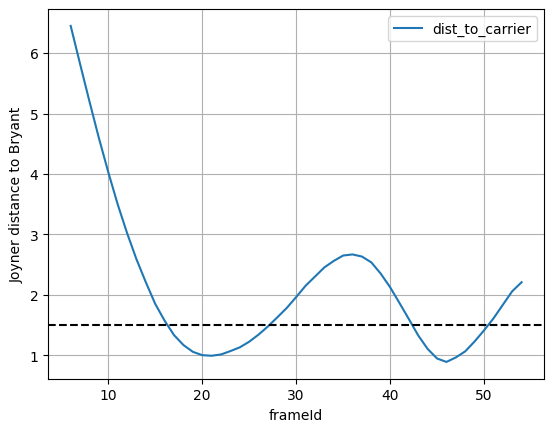

In [19]:
defenders.query(
    "gameId == 2022091801 & playId == 2090 & nflId_defender == 41270"
).plot("frameId", "dist_to_carrier")
plt.grid()
plt.ylabel("Joyner distance to Bryant")
plt.xlabel("frameId")
plt.axhline(1.5, color="k", ls="--")
plt.show()

In [20]:
tackle_opps.weight.value_counts()

weight
1.000000    16876
0.500000      230
0.333333        3
Name: count, dtype: int64

### Aside: Feature Investigation

Before jumping into models, let's make sure the features we have chosen are sensible, i.e., that they offer some ability to distinguish between tackles and misses. The plots below tell us what proportion of each outcome occurs at the given feature value. The top-level takeaway is that the differences between the blue and orange lines indicates that these features are indeed capable of describing whether a tackle is more likely to be a success or a miss.

For instance, relative to successful tackles, missed tackles are generally characterized by:

* higher relative momentum `p_rel` (i.e., larger impact collisions)
* larger distance to sideline (forcing out-of-bounds is not an option)
* _not_ following a pass reception
* longer time since receipt (less focus on receiving the ball = more focus on avoiding tacklers)

while these plots are interesting, the reason we still prefer to use a model is to give us an overall probability _controlling for all these factors simultaneously_. For instance, high impact collisions seem most likely to happen when, e.g., RBs collide with linebackers (= not a pass) in the middle of the field (= away from the sideline).

We also see, perhaps unsurprisingly, that assists are a very different beast from tackles. So, we will exclude them from TAR; extending TAR to account for assists can be another AFI.

In [21]:
tackle_opps["outcome"] = np.where(
    tackle_opps.tackle == 1,
    "tackle",
    np.where(
        tackle_opps.assist == 1,
        "tackle assist",
        "miss"
    )
)

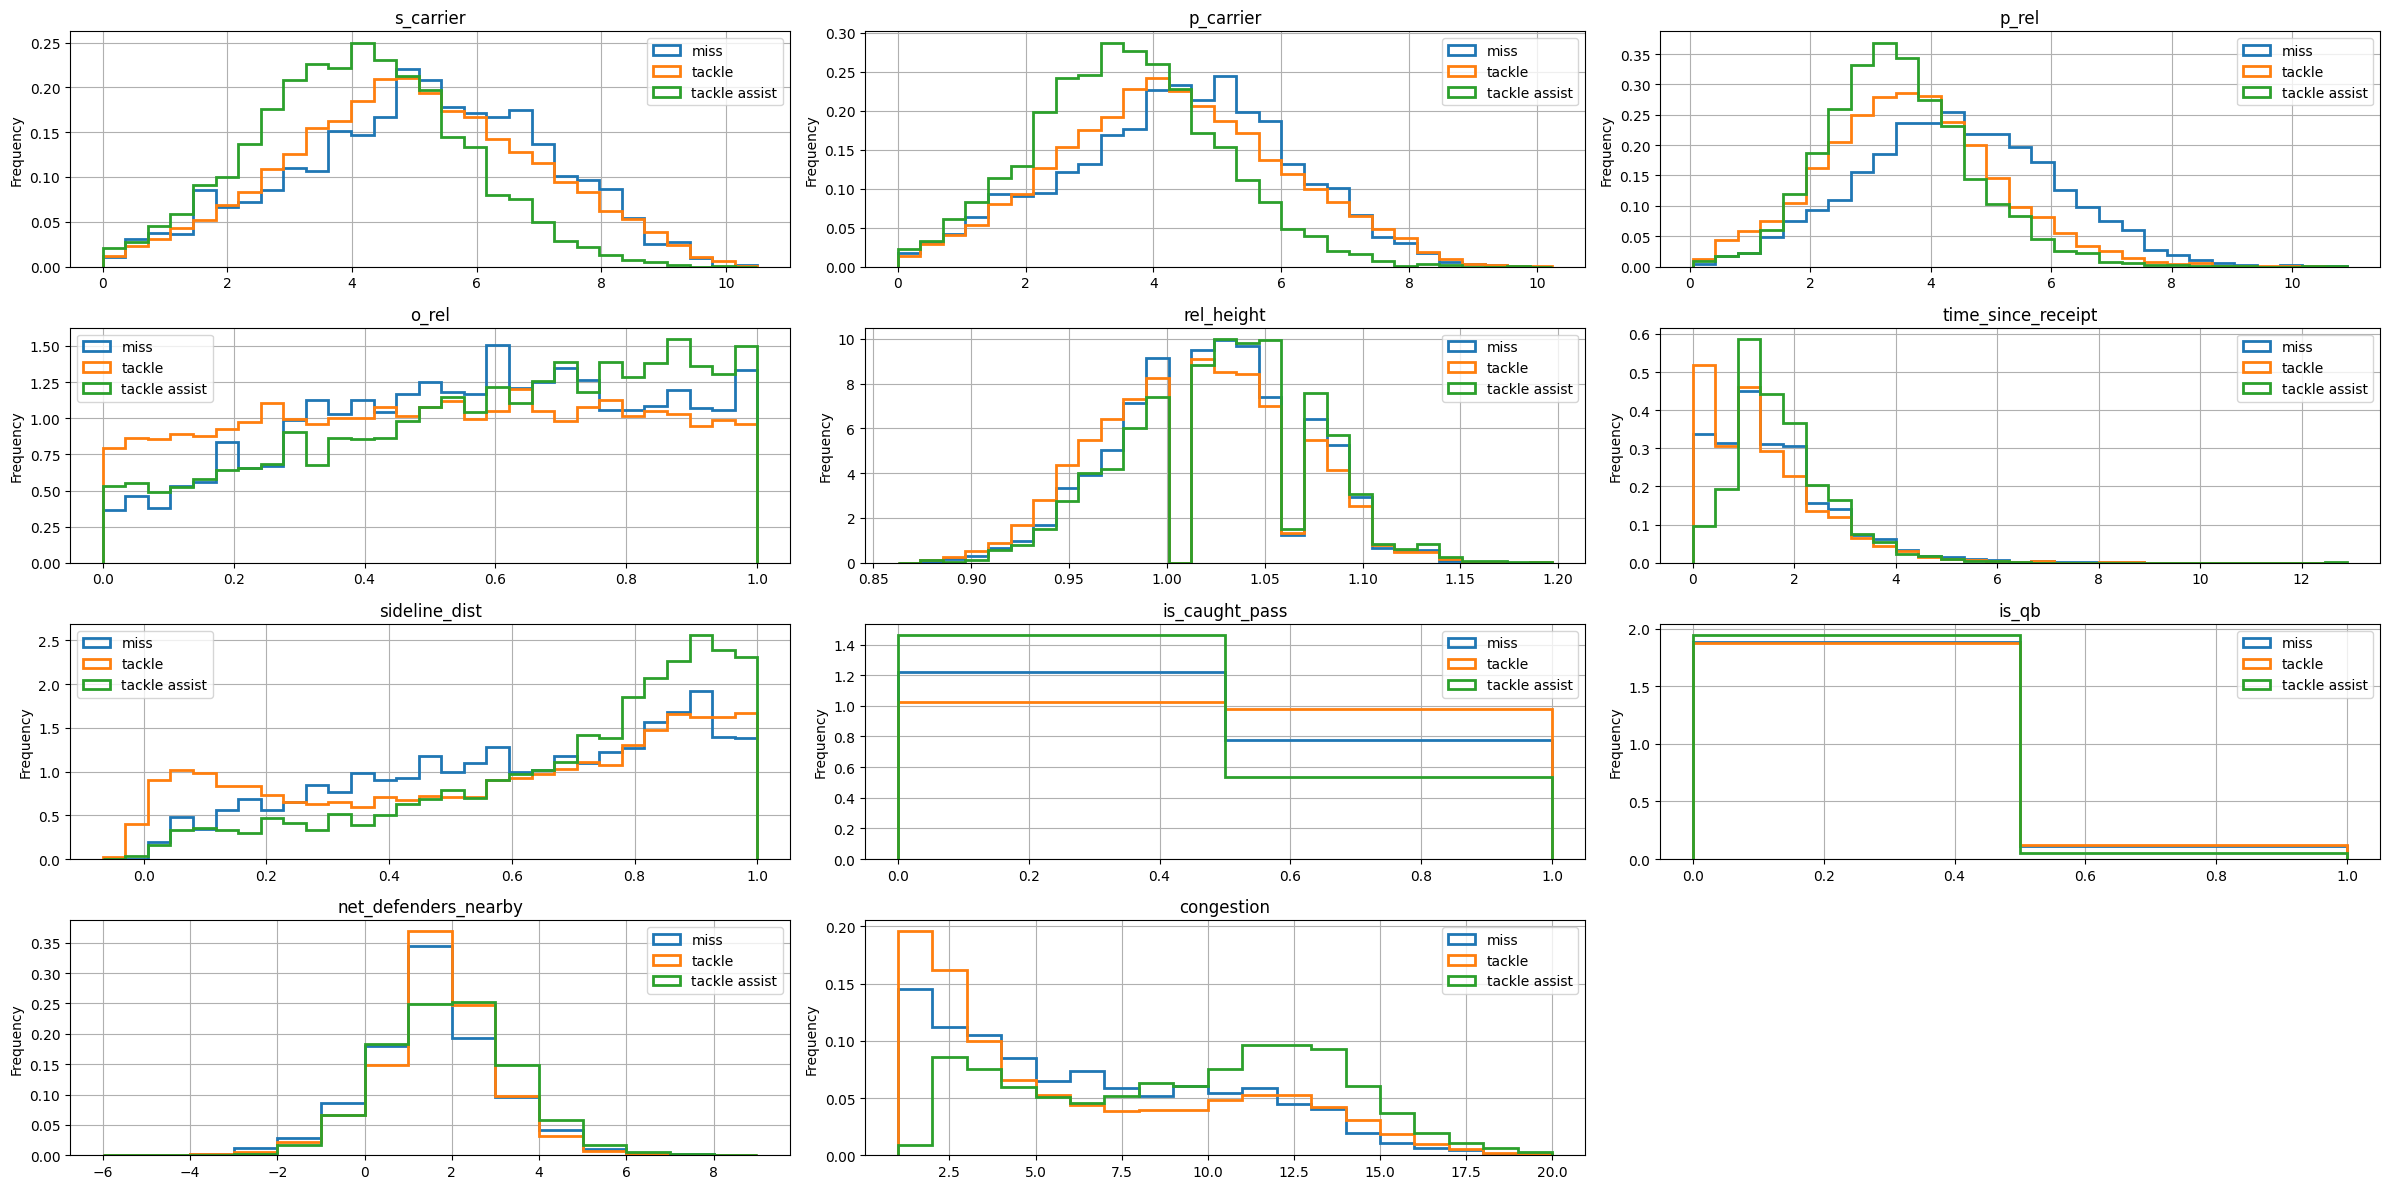

In [22]:
hkw = dict(histtype="step", density=True, lw=2)
maxbins = 30
fig = plt.figure(figsize=(24, 12))
for i, fn in enumerate(tackle_features):
    ax = fig.add_subplot(4, 3, i+1)
    if tackle_opps[fn].nunique() == 2:
        hbins = 2
    elif tackle_opps[fn].nunique() < maxbins:
        hbins = np.arange(tackle_opps[fn].min(), tackle_opps[fn].max()+1)
    else:
        hbins = np.linspace(tackle_opps[fn].min(), tackle_opps[fn].max(), maxbins)
    tackle_opps.groupby("outcome")[fn].plot.hist(
        ax=ax, bins=hbins, **hkw
    )
    ax.legend(loc="best")
    ax.set_title(fn)
    ax.grid()
plt.tight_layout()
plt.show()

### Model Fitting and Verification

Time to fit the model. We will do a basic train-test split not so much because we are using this as a predictive model and care about heldout performance, but more just to ensure we are not overfitting. This shouldn't be a problem with such a simple _descriptive_ model and simple features, but it helps me feel better about applying the predictions to the fitting/training data. Though, having more data for fitting would be better: a proper application might involve fitting on all previous years' data, and using that model throughout the season.

In [23]:
w = (1 - tackle_opps.assist) * tackle_opps.weight
y = tackle_opps[["tackle", "assist"]].sum(axis=1)
x = tackle_opps[tackle_features]

xtr, xte, ytr, yte, wtr, wte = train_test_split(x, y, w, random_state=1337, test_size=0.2)

# standard scaling
mu, sigma = xtr.mean(axis=0), xtr.std(axis=0)
xtr_ss = (xtr - mu) / sigma
xte_ss = (xte - mu) / sigma

In [24]:
tackle_models = dict(
    linear=LogisticRegression(),
    tree=DecisionTreeClassifier(min_samples_split=0.05, max_depth=10)
)

for name, model in tackle_models.items():
    print(f"### model = {name} ###")
    _tackle_model = model.fit(xtr_ss, ytr, sample_weight=wtr)

    train_acc = _tackle_model.score(xtr_ss, ytr, wtr)
    ptr = _tackle_model.predict_proba(xtr_ss)[:,1]
    train_f1 = precision_recall_fscore_support(ytr, (ptr > 0.5).astype("int"), sample_weight=wtr)[2][0]
    train_roc = roc_auc_score(ytr, ptr, sample_weight=wtr)
    print(f"train: acc = {train_acc:.4f}, f1 = {train_f1:.4f}, roc auc = {train_roc:.4f}")

    test_acc = _tackle_model.score(xte_ss, yte, wte)
    pte = _tackle_model.predict_proba(xte_ss)[:,1]
    test_f1 = precision_recall_fscore_support(yte, (pte > 0.5).astype("int"), sample_weight=wte)[2][0]
    test_roc = roc_auc_score(yte, pte, sample_weight=wte)
    print(f"test: acc = {test_acc:.4f}, f1 = {test_f1:.4f}, roc auc = {test_roc:.4f}")

### model = linear ###
train: acc = 0.8278, f1 = 0.0455, roc auc = 0.6864
test: acc = 0.8371, f1 = 0.0411, roc auc = 0.6735
### model = tree ###
train: acc = 0.8299, f1 = 0.0385, roc auc = 0.7378
test: acc = 0.8361, f1 = 0.0284, roc auc = 0.6854


So the linear model looks like it performs reasonably well, and is not _too_ much better in sample (compared to the tree). Moreover, looking at the feature weights below, we see patterns that accord with out intuition, which is always a good suggestion that the model can be trusted, e.g.,

* relative momentum is the most important factor in determining tackle difficulty (high momentum = harder)
* congestion makes tackles easier, as does a surplus of defenders relative to blockers
* QBs are easier to tackle

and so on.

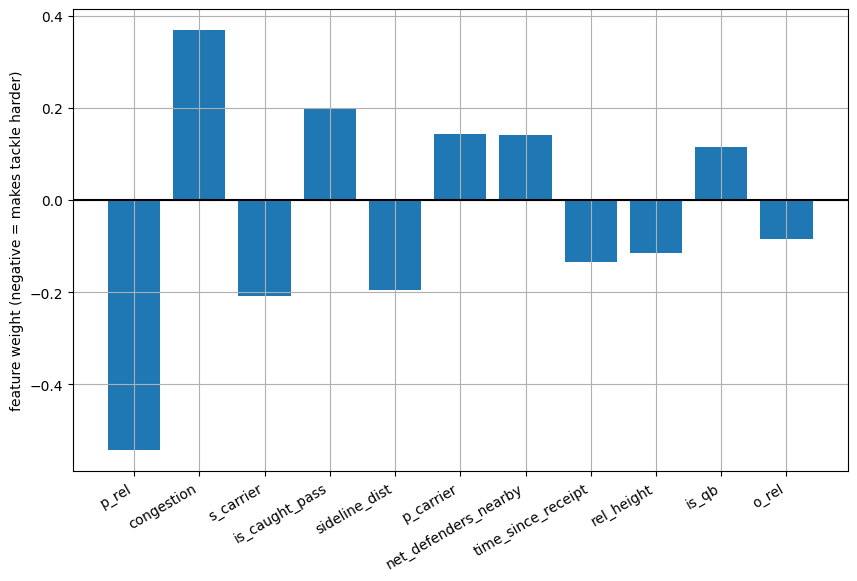

In [25]:
def plot_linear_model_features(tackle_features, model, description):
    xes = np.arange(len(tackle_features))
    cf = model.coef_[0] if model.coef_.ndim > 1 else model.coef_
    sidxes = np.abs(cf).argsort()[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(xes, cf[sidxes])
    plt.xticks(
        xes, 
        labels=[tackle_features[_i] for _i in sidxes], 
        ha="right", 
        rotation=30
    )
    plt.grid()
    plt.axhline(color="k")
    plt.ylabel(f"feature weight ({description})")
    plt.show()
    
plot_linear_model_features(tackle_features, tackle_models["linear"], "negative = makes tackle harder")

### Computing TAR (finally)

Now that we have our model (we'll use the linear model, as it appears to perform comparably and be less overfit), we can compute TAR, and add it to the tackle information.

In [26]:
tackle_model = tackle_models["linear"]
p_tackle = tackle_model.predict_proba(
    (tackle_opps[tackle_features] - mu) / sigma
)[:,1]
tackle_opps["p_tackle"] = p_tackle
tackle_opps["TAR"] = tackle_opps.tackle * (1 - p_tackle)
tackle_opps["TAR+"] = tackle_opps.TAR - tackle_opps.pff_missedTackle * p_tackle * tackle_opps.weight
tackle_opps["missed"] = tackle_opps.pff_missedTackle * tackle_opps.weight

Let's look at our Bryant/Joyner example again. We see Joyner first misses a somewhat difficult tackle (probability = 46.5%), which has no impact on his TAR but a negative impact on his TAR+. He subsequently makes a much easier tackle (probability = 68.8%), which gives a small positive contribution to his TAR and TAR+. His overall TAR+ for the play is negative.

In [27]:
tackle_opps.query(
    "gameId == 2022091801 & playId == 2090 & nflId_defender == 41270"
)

,gameId,playId,nflId_carrier,displayName_carrier,frameId,time,jerseyNumber_carrier,club_carrier,playDirection,x_carrier,y_carrier,s_carrier,a_carrier,dis_carrier,o_carrier,dir_carrier,event,ballCarrierId,startFrameId,receiptEvent,endFrameId,endEvent,x_final,s_downfield,nflId_defender,displayName_defender,jerseyNumber_defender,club_defender,x_defender,y_defender,s_defender,a_defender,dis_defender,o_defender,dir_defender,dist_to_carrier,blockers_nearby,defenders_nearby,weight_carrier,position_carrier,height_m_carrier,weight_defender,position_defender,height_m_defender,tackle,assist,forcedFumble,pff_missedTackle,tidx,weight,p_carrier,p_rel,o_rel,rel_height,time_since_receipt,sideline_dist,is_caught_pass,is_qb,net_defenders_nearby,congestion,outcome,p_tackle,TAR,TAR+,missed
2322,2022091801,2090,52523,Harrison Bryant,17,2022-09-18 14:39:13.500000,88,CLE,right,63.81,40.93,5.59,0.75,0.56,127.91,160.95,NaN,52523,6,pass_outcome_caught,54,tackle,71.32,1.824538,41270,Lamarcus Joyner,29,NYJ,65.14,40.80,3.01,4.36,0.28,230.87,182.68,1.336338,0,1,240,TE,1.9558,185,SS,1.7272,0,0,0,1,2347,1.0,5.3664,3.398842,0.572000,0.883117,1.1,0.464165,1,0,1,1,miss,0.890082,0.000000,-0.890082,1.0
2323,2022091801,2090,52523,Harrison Bryant,43,2022-09-18 14:39:16.099999,88,CLE,right,68.65,27.44,5.18,1.84,0.53,141.93,135.53,NaN,52523,6,pass_outcome_caught,54,tackle,71.32,3.628775,41270,Lamarcus Joyner,29,NYJ,69.59,28.38,4.35,3.02,0.44,223.95,175.16,1.329361,1,3,240,TE,1.9558,185,SS,1.7272,1,0,0,0,2348,1.0,4.9728,3.230092,0.455667,0.883117,3.7,0.970356,1,0,2,4,tackle,0.869955,0.130045,0.130045,0.0


In [28]:
player_tar_df = tackle_opps.groupby(
    ["displayName_defender", "nflId_defender"]
)[["tackle", "missed", "TAR", "TAR+"]].sum()
team_tar_df = tackle_opps.groupby(
    ["club_defender"]
)[["tackle", "missed", "TAR", "TAR+"]].sum()

We'll postpone any further insights into performance until after the computation of our second metric.

# Metric 2: Yards Saved

Letting $y$ represent the number of forward yards achieved by the carrier from the tackle opportunity to the end of the tackle, we define the "yards saved" (YS) in a tackle to be
\begin{align}
YS = \sum_{tackles} \mathbb{E}(y | \text{context}) - y
\end{align}
where $\mathbb{E}(y | \text{context})$ denotes a model that predicts, given the tackle context, how many forward yards the carrier was expected to achieve. So, if in a given tackle the carrier is expected to get 3.5 more yards and only gets 1.4, then the tackle saved $3.5 - 1.4 = 2.1$ yards.

To build this model, we will use the same setup as above. The biggest differences are

1. this metric only applies to successful tackles, and
2. we replace `s_carrier` with `s_downfield`, the component of the carrier's speed that is pointing downfield, since we predominantly care about how far they traveled in this direction. Below you can see that carriers tend to enter tackle opportunities with positive downfield speed (good), and that this relates _approximately_ linearly to the number of yards they ultimately attain after the start of the tackle.

We don't bother with the train-test split here, although it would be _better_, since we are just going to use simple features and a linear regression model for $\mathbb{E}(y | \text{context})$ (which didn't cause much overfitting for TAR).

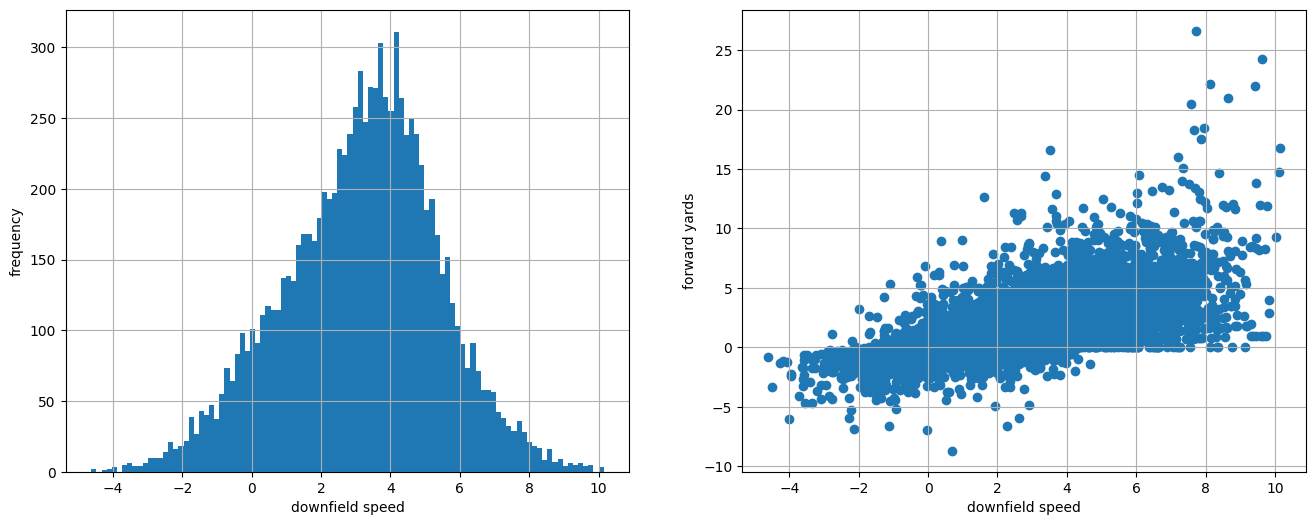

In [29]:
tackles_only = tackle_opps[tackle_opps.tackle == 1].reset_index(drop=True)
forward_yards = (tackles_only.x_final - tackles_only.x_carrier) * (1 - 2 * (tackles_only.playDirection == "left"))

_, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].hist(
    tackles_only.s_downfield, bins=100
)
axes[0].grid()
axes[0].set_xlabel("downfield speed")
axes[0].set_ylabel("frequency")

axes[1].scatter(
    tackles_only.s_downfield, forward_yards
)
axes[1].grid()
axes[1].set_xlabel("downfield speed")
axes[1].set_ylabel("forward yards")

plt.show()

The model is fit, and its feature weights are shown, below. A few notable things

1. As anticipated, `s_downfield` is the main predictor of how much further the carrier is going to go.
2. While large `p_rel` made tackling harder, it also _makes it more likely that the carrier will be pushed back/achieve fewer yards_! So, there's a tradeoff here, with possible tactical (or, at least, technique) applications.
3. The other contributions are relatively intuitive, which is encouraging (e.g., QBs gain less ground, being away from the sideline helps carriers go further, a surplus of defenders nearby prevents them from going further etc.)

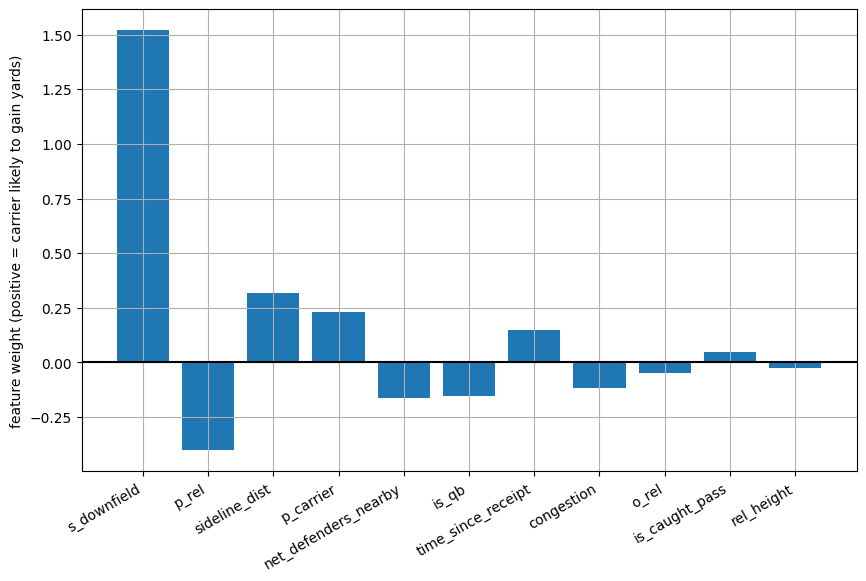

In [30]:
yds_saved_features = ["s_downfield"] + tackle_features[1:]

x = tackles_only[yds_saved_features]
x_ss = (x - x.mean()) / x.std()

lr = LinearRegression().fit(
    x_ss, forward_yards
)
plot_linear_model_features(yds_saved_features, lr, "positive = carrier likely to gain yards")

Which leaves us with what we need to compute our YS metric for the tackles. We also note that the flipside of a tackle is trying to break a tackle, so we can consider a similar "anti-YS" metric for carriers to see who manages to get more after the tackle than they should.

In [31]:
tackles_only["YS"] = lr.predict(x_ss) - forward_yards
defender_yds_saved = tackles_only.groupby(
    ["displayName_defender", "nflId_defender"]
).YS.sum()
carrier_extra_yards = -tackles_only.groupby(
    ["displayName_carrier", "nflId_carrier"]
).YS.sum()
team_yds_saved = tackles_only.groupby(
    ["club_defender"]
).YS.sum()

# Analysing Players and Teams using TAR and YS

**NOTE: this analysis was done with a bug in TAR computation (forgot to standard scale features before running prediction), and I have already rewritten it on Kaggle and don't right now feel like fixing it here in detail.**

~~First, let's use these metrics to look at some individual players, and in particular see who TAR/YS thinks are particularly good tacklers. Looking toward the upper right of the plots below really seems to identify 3 players who are having impressive seasons:~~

...

~~It's interesting to note these guys are outside defenders: it seems plausible that TAR favors "open field" tacklers who are making high speed tackles at low congestion. This is in contract to "vanilla" tackles; if you  look at the top 10 defenders by tackles, all of them are ILB/OLB. By comparison, only one of these guys is in the top 20; TAR and YS give an orthogonal way of viewing tackles that allows them to stand out from the crowd.~~

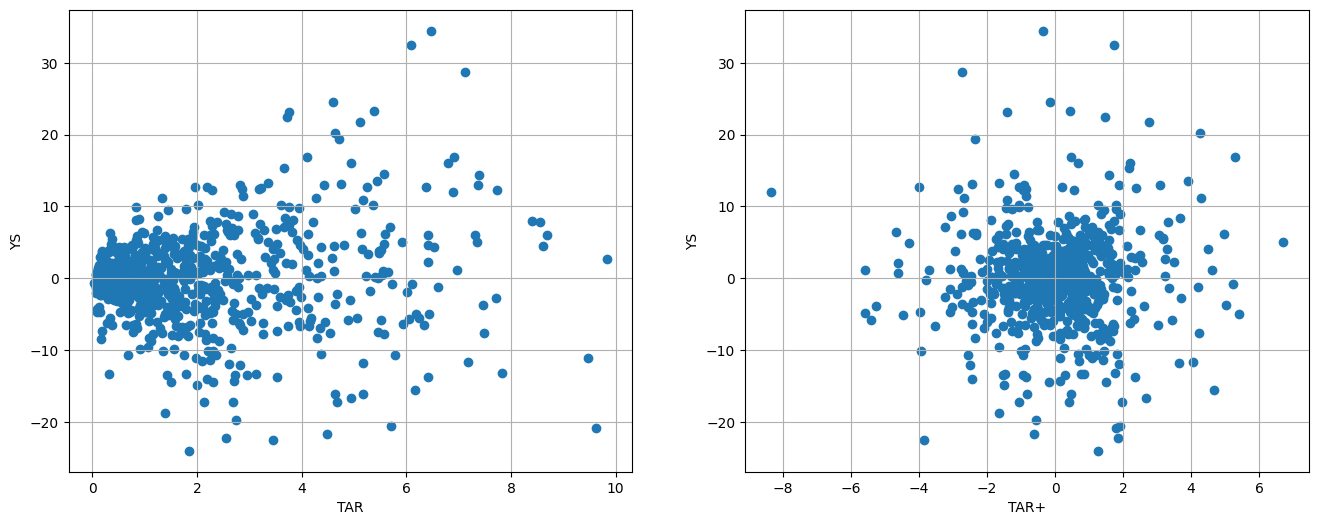

In [32]:
player_metrics = player_tar_df.join(defender_yds_saved)
player_metrics.missed = player_metrics.missed.fillna(0).astype("int")
player_metrics["YS_per_tackle"] = player_metrics.YS / player_metrics.tackle

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(player_metrics.TAR, player_metrics.YS)
axes[0].set_xlabel("TAR")
axes[1].scatter(player_metrics["TAR+"], player_metrics.YS)
axes[1].set_xlabel("TAR+")

for ax in axes:
    ax.grid()
    ax.set_ylabel("YS")

plt.show()

In [34]:
player_metrics.sort_values("tackle", ascending=False).head(10)

,,tackle,missed,TAR,TAR+,YS,YS_per_tackle
displayName_defender,nflId_defender,,,,,,
Foyesade Oluokun,46269,59,11,8.690693,-0.136279,6.062314,0.102751
Jordyn Brooks,52435,58,10,9.620120,1.802969,-20.852431,-0.359525
C.J. Mosley,41243,55,8,9.827342,3.233142,2.723488,0.049518
Zaire Franklin,46304,51,11,8.615052,0.030681,4.458279,0.087417
Jordan Hicks,42427,50,5,7.709055,3.702809,-2.782462,-0.055649
Roquan Smith,46077,49,7,7.382620,1.595874,14.385143,0.293574
Pete Werner,53489,48,7,7.365475,1.886169,13.042141,0.271711
T.J. Edwards,48516,47,8,7.836422,1.762553,-13.240746,-0.281718
Bobby Okereke,47872,46,4,7.491352,4.227646,-7.582309,-0.164833


**Which teams are perform well according to TAR and YS?** One team distinguishing themselves here is DET; they have one of the highest TAR scores in spite of having 50 fewer tackles than SEA and CAR. And, their TAR+ is higher. Interestingly, the top teams in TAR are not necessarily the top in YS, which potentially points to a difference in tackling styles (as we've seen that the setup for a more likely tackle differs from that for a yard-saving tackle). For YS, LV and TEN really stand out: they're middle-of-the-pack in terms of tackles and TAR, but their players have saved over 75 yards so far this season with some tough tackling!

In [39]:
team_metrics = team_tar_df.join(team_yds_saved)
team_metrics.missed = team_metrics.missed.astype("int")
team_metrics.sort_values("TAR", ascending=False)

,tackle,missed,TAR,TAR+,YS
club_defender,,,,,
SEA,346,65,57.284580,6.284196,-7.874405
CAR,355,76,54.628719,-2.767090,-12.289674
IND,323,42,54.612088,22.134793,9.906763
DET,304,49,53.844316,17.816620,-1.155192
HOU,306,86,53.299277,-13.295971,9.387833
ATL,331,76,52.975016,-7.192919,43.080207
NYJ,323,64,51.922937,2.586827,19.809050
CHI,319,68,51.688356,-0.324592,15.814468
ARI,325,69,51.419838,-2.014238,-58.646752
